# Session 4 : Representation and dictionary learning

>Intelligence Artificielle & Machine Learning pour la modélisation de séries temporelles et de signaux<br />
>Master 1 Parcours IA ENS Paris Saclay<br />
>Laurent Oudre (laurent.oudre@ens-paris-saclay.fr)

This fourth session is dedicated to the description of dictionary and representation learning for time series. Slides are available at http://www.laurentoudre.fr/signalml.html

1. **Library and data loading**
2. **Exploratory study**
3. **Sparsity in the frequency domain**
4. **Sparse coding with known dictionary**
5. **Dictionary learning**

## 1. Library and data loading

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal
from sporco.admm import bpdn

In [2]:
plt.rcParams['figure.figsize'] = (10,5)

In [3]:
# Data loading
npzfile = np.load('Session4.npz')
x=npzfile['x']
t=npzfile['t']
Fs=1

# First investigations
N=np.size(x)
print("Number of samples : {N}".format(**locals()))
print("First year : {t[0]}".format(**locals()))
print("Last year : {t[136]}".format(**locals()))

Number of samples : 137
First year : 1880.0
Last year : 2016.0


## 2. Exploratory study

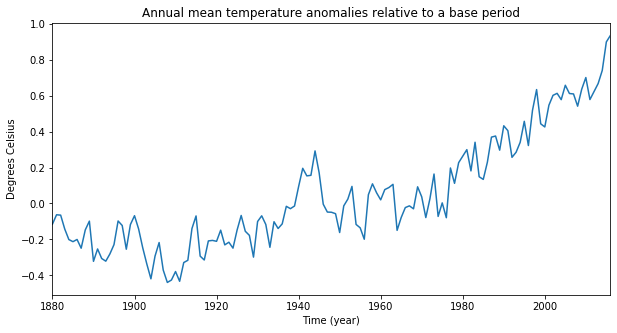

In [4]:
# x[n] as a function of time
plt.plot(t,x)
plt.xlim((t[0],t[-1]))
plt.xlabel('Time (year)')
plt.ylabel('Degrees Celsius')
plt.title('Annual mean temperature anomalies relative to a base period')
plt.show()

## 3. Sparsity in the frequency domain

In [5]:
# Function to compute the centered Fast Fourier Transform (FFT)
def my_fft(x,Fs):
    N=np.size(x)
    #Computation of the FFT
    X=np.fft.fft(x)
    X=np.fft.fftshift(X)
    # Computation the frequency vector
    f=np.fft.fftfreq(N, d=1/Fs)
    f=np.fft.fftshift(f)
    return X,f

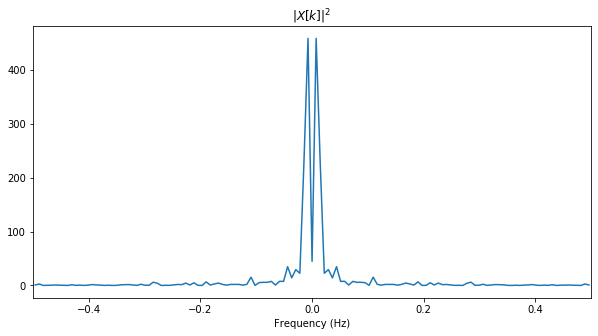

In [6]:
# Display of the squared absolute value of the DFT as a function of frequency
X,f=my_fft(x,Fs)
plt.plot(f,np.abs(X)**2)
plt.xlim((-Fs/2,Fs/2))
plt.xlabel('Frequency (Hz)')
plt.title('$|X[k]|^2$')
plt.show()

C:\Users\Laurent\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


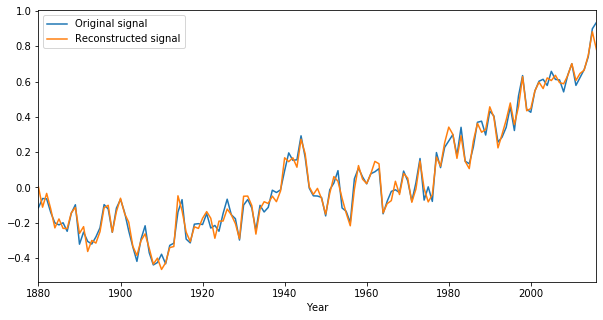

Percentage of conserved samples: 51.824817518248175
Reconstruction error (RMSE): 0.03871539895540755


In [7]:
# Supression of the small coefficients
threshold=1
X=np.fft.fft(x)
X[np.abs(X)**2<threshold]=0 # Thresholding
y=np.fft.ifft(X) # Reconstruction
plt.plot(t,x)
plt.plot(t,y)
plt.xlim((t[0],t[-1]))
plt.xlabel('Year')
plt.legend(('Original signal', 'Reconstructed signal'))
plt.show()
p=100*(np.size(X)-np.sum(np.abs(X)**2<threshold))/np.size(X)
e=np.sqrt(np.mean(np.power(np.abs(x-y),2)))
print("Percentage of conserved samples: {p}".format(**locals()))
print("Reconstruction error (RMSE): {e}".format(**locals()))

## 4. Sparse coding with known dictionary

Given a signal $\mathbf{x}$, we seek for a representation  $$\mathbf{x} = \mathbf{D} \mathbf{z}$$ where
* $\mathbf{D}$ is a dictionary of signals (such as the Fourier basis)
* $\mathbf{z}$ is a sparse vector

The problem of finding $\mathbf{z}$ from $\mathbf{x}$, $\mathbf{D}$ and some sparsity criteria is called **sparse coding**. Several solvers exist for this problem, depending on the used sparsity criteria. 

### 4.1 L0-regularized problem

 One solution consists in solving the L0-regularized optimization problem
$$\mathbf{z}^* = \underset{\|\mathbf{z}\|_0 = K_0}{\operatorname{argmin}}  \|\mathbf{x} - \mathbf{D} \mathbf{z}\|_2^2$$ This minimization can be performed by using Hard Thresholding Gradient Descent.

In [8]:
# Fourier dictionary
N=np.size(x)
n = np.arange(N)/Fs
Nh=np.int(np.floor(N/2))
D=np.zeros((N,2*Nh+1))
D[:,0]=np.ones(N)
for k in range(Nh):
    f0=Fs/N
    D[:,2*k+1]=np.cos(2*np.pi*f0*(k+1)*n)
    D[:,2*k+2]=np.sin(2*np.pi*f0*(k+1)*n)

In [9]:
# Sparse coding based on Hard Thresholding Gradient Descent
def sparse_coding(x,D,k):
    niter = 100
    gamma = 1/(np.linalg.norm(D,2)**2)
    N=np.size(x)
    z=np.zeros((N,))
    for i in range(niter):
        r=np.dot(D,z)-x
        c=z - gamma * np.dot(np.transpose(D),r)
        ind=np.argsort(np.abs(c))
        c[ind[np.arange(0,N-k)]]=0        
        z=c
    return z

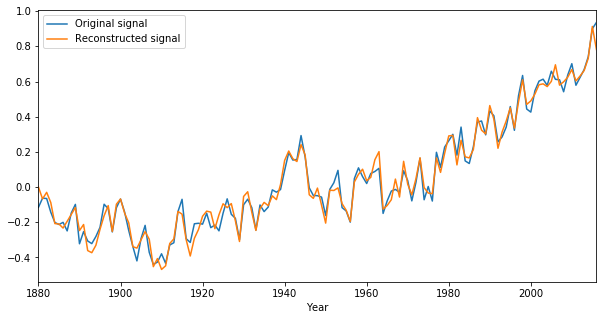

Percentage of conserved samples: 36.496350364963504
Reconstruction error (RMSE): 0.043775808559691744


In [10]:
# Reconstruction with L0-regularized sparse coding
k=50 # Number of conserved coefficients
z=sparse_coding(x,D,k)
y=np.dot(D,z) # Reconstruction
plt.plot(t,x)
plt.plot(t,y)
plt.xlim((t[0],t[-1]))
plt.xlabel('Year')
plt.legend(('Original signal', 'Reconstructed signal'))
plt.show()
p=100*(k)/np.size(z)
e=np.sqrt(np.mean(np.power(np.abs(x-y),2)))
print("Percentage of conserved samples: {p}".format(**locals()))
print("Reconstruction error (RMSE): {e}".format(**locals()))

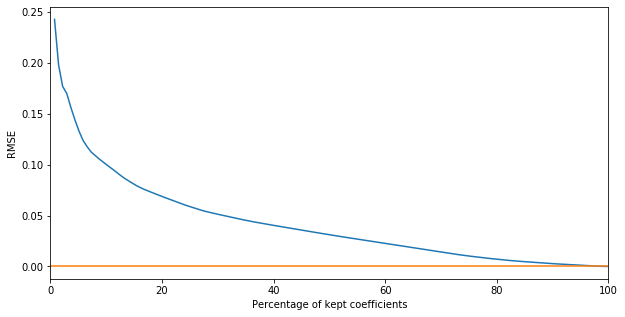

In [11]:
# RMSE as a function of the percentage of kept coefficients
Nd=np.shape(D)
e=np.zeros((Nd[1],))
for k in range(1,Nd[1]+1):
    z=sparse_coding(x,D,k)
    y=np.dot(D,z)
    e[k-1]=np.sqrt(np.mean(np.power(np.abs(x-y),2)))

plt.plot(100*np.arange(1,Nd[1]+1)/Nd[1],e)
plt.plot([0,100],[0, 0])
plt.xlim((0,100))
plt.xlabel('Percentage of kept coefficients')
plt.ylabel('RMSE')
plt.show()

### 4.2 L1-regularized problem

 Another solution consists in solving the L1-regularized optimization problem (often referred to as the **LASSO problem**
$$\mathbf{z}^* = \underset{\mathbf{z}}{\operatorname{argmin}} \|\mathbf{x} - \mathbf{D}\mathbf{z}\|_2^2 + \lambda \|\mathbf{z}\|_1$$ This minimization can be performed by using ADMM or FISTA.

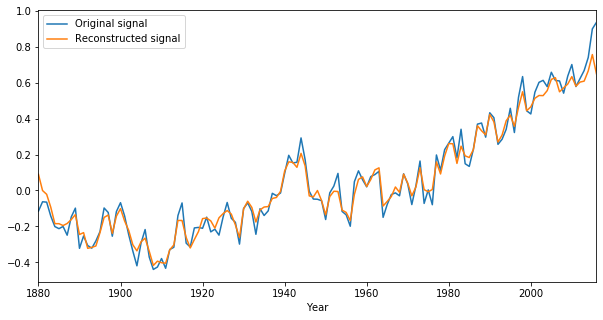

Percentage of conserved samples: 60.583941605839414
Reconstruction error (RMSE): 0.42519732464103205


In [12]:
# Reconstruction with L1-regularized sparse coding
gamma=0.5 # Sparsity parameter
x2=np.reshape(x,(N,1))
opt = bpdn.BPDN.Options({'Verbose': False, 'MaxMainIter': 500,
                    'RelStopTol': 1e-8, 'AutoRho': {'RsdlTarget': 1.0}})
b = bpdn.BPDN(D, x2, gamma, opt)
z = b.solve()
y=np.dot(D,z) # Reconstruction
plt.plot(t,x)
plt.plot(t,y)
plt.xlim((t[0],t[-1]))
plt.xlabel('Year')
plt.legend(('Original signal', 'Reconstructed signal'))
plt.show()
p=100*np.sum(z!=0)/np.size(z)
e=np.sqrt(np.mean(np.power(np.abs(x-y),2)))
print("Percentage of conserved samples: {p}".format(**locals()))
print("Reconstruction error (RMSE): {e}".format(**locals()))

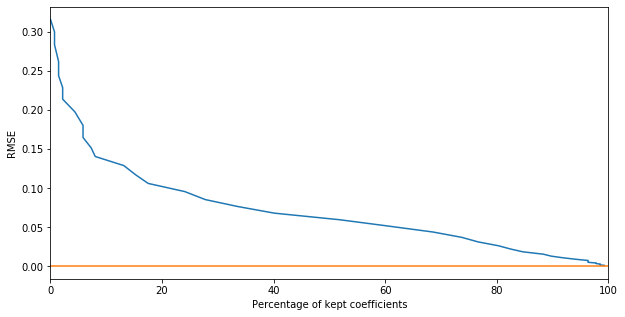

In [13]:
# RMSE as a function of the percentage of kept coefficients
gamma_range=np.logspace(-2, 6, 100)
Ne=np.size(gamma_range)
e=np.zeros((Ne,))
p=np.zeros((Ne,))
for ig in range(Ne):
    b = bpdn.BPDN(D, x2, gamma_range[ig], opt)
    z = b.solve()
    y=np.dot(D,z) # Reconstruction
    e[ig]=np.sqrt(np.mean(np.power(np.abs(x2-y),2)))
    p[ig]=100*np.sum(z!=0)/np.size(z)

plt.plot(p,e)
plt.plot([0,100],[0, 0])
plt.xlim((0,100))
plt.xlabel('Percentage of kept coefficients')
plt.ylabel('RMSE')
plt.show()

## 5. Dictionary learning

When the dictionary is not known in advance, it has to be learned from the data. In this case, we use an alternate minimization:
* Sparse coding (here L0, but L1 could be used too !)
$$\mathbf{Z}^* = \underset{\forall k, \|\mathbf{z_k}\|_0=K_0}{\operatorname{argmin}} \|\mathbf{X} - \mathbf{D}\mathbf{Z}\|_F^2$$
* Dictionary learning
  $$\mathbf{D}^* = \underset{\forall k, \|\mathbf{d_k}\|_2 = 1}{\operatorname{argmin}} \|\mathbf{X} - \mathbf{D} \mathbf{Z}\|_F^2$$ 

In [14]:
# Put the original signal into overlapping frame
def create_frames(x,Nw,Nh):
    X = np.array([ x[i:i+Nw] for i in range(0,len(x)-Nw,Nh) ])
    X=np.transpose(X)
    return X

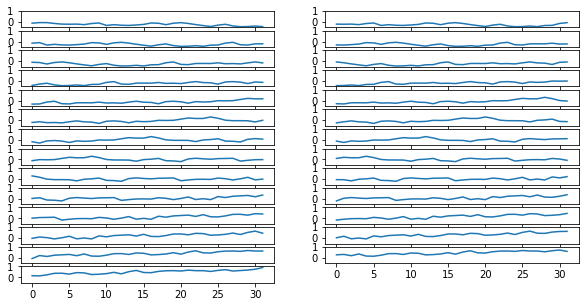

In [15]:
Nw=32 # Number of samples per frame
Nh=int(Nw/8); # Hop length
X = create_frames(x,Nw,Nh)
Nw,Nd=np.shape(X)

# Plot of the original signal (in frames)
for i in range(Nd):
    plt.subplot(np.floor(Nd/2)+1,2,i+1)
    plt.plot(X[:,i])
    plt.ylim([-0.5,1])


In [16]:
# Generate random dictionary
K = 5 # Number of atoms
D=np.random.randn(Nw,K)
for k in range(K):
    D[:,k]=(D[:,k]-np.mean(D[:,k]))
    D[:,k]=D[:,k]/np.sqrt(np.sum(D[:,k]**2))

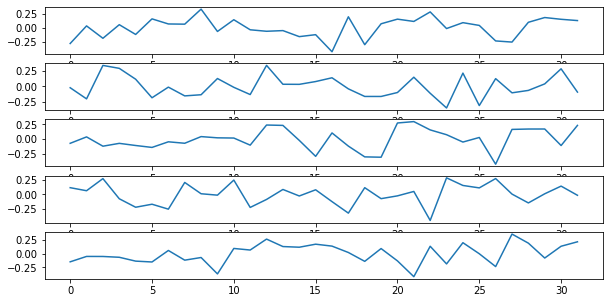

In [17]:
# Plot of the initialized dictionary
for i in range(K):
    plt.subplot(K,1,i+1)
    plt.plot(D[:,i])

In [18]:
# Sparse coding based on Hard Thresholding Gradient Descent (matrix version)
def sparse_coding_matrix(X,D,K0):
    niter = 100
    gamma = 1/(np.linalg.norm(D,2)**2)
    Nw,Nd=np.shape(X)
    Nw,K=np.shape(D)
    Z=np.zeros((K,Nd))
    for i in range(niter):
        r=np.dot(D,Z)-X
        C=Z - gamma * np.dot(np.transpose(D),r)
        for j in range(Nd):
            c=C[:,j]
            ind=np.argsort(np.abs(c))
            c[ind[np.arange(0,K-K0)]]=0        
            Z[:,j]=c
    return Z

In [19]:
# Dictionary learning based on Proximal Gradient Descent (matrix version)
def dictionary_learning_matrix(X,Z,D):
    niter = 100
    gamma = 1/(np.linalg.norm(Z,2)**2)
    Nw,Nd=np.shape(X)
    Nw,K=np.shape(D)
    for i in range(niter):
        r=np.dot(D,Z)-X
        D=D - gamma * np.dot(r,np.transpose(Z))
        for j in range(K):
            D[:,j]=D[:,j]/np.sqrt(np.sum(D[:,j]**2))
    return D

In [20]:
# Perform the alternate minimization (sparse coding + dictionary learning)
K0=2
for i in range(50):
    Z=sparse_coding_matrix(X,D,K0)
    D=dictionary_learning_matrix(X,Z,D)

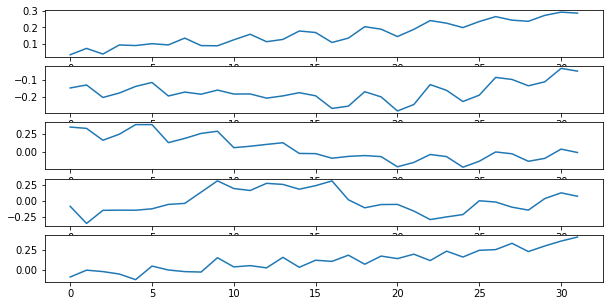

In [21]:
# Plot of the learned dictionary
for k in range(K):
    plt.subplot(K,1,k+1)
    plt.plot(D[:,k])

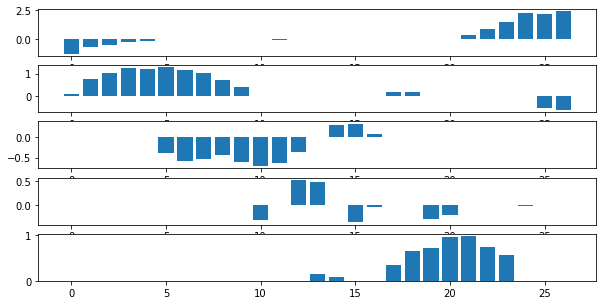

In [22]:
# Plot of the learned activations
for k in range(K):
    plt.subplot(K,1,k+1)
    plt.bar(np.arange(Nd),Z[k,:])

In [23]:
# Inverse the frames to retrieve the original signal
def icreate_frames(X,Nh):
    Nw,Nd=np.shape(X)
    Y=np.nan*np.ones(((Nd-1)*Nh+Nw,Nd))
    for i in range(Nd):
        Y[i*Nh:i*Nh+Nw,i]=X[:,i]
    Y=np.transpose(Y)
    y=np.nanmean(Y,axis=0)
    return y 

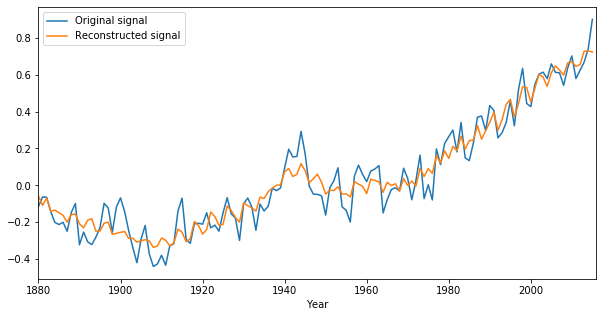

In [24]:
# Approximated signal with dictionary learning
X_bar=np.dot(D,Z)
y=icreate_frames(np.dot(D,Z),Nh)

plt.plot(t[:-1],x[:-1])
plt.plot(t[:-1],y)
plt.xlim((t[0],t[-1]))
plt.xlabel('Year')
plt.legend(('Original signal', 'Reconstructed signal'))
plt.show()